# LLM Energy Efficency Data Analysis

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the data
devices = ['SRV', 'PC', 'RPI']
experiments = ['baseline', 'blanks', 'guideline', 'keyword']


def preprocess_data(df):

	# Remove all columns that start with 'CPU_FREQUENCY'
	frequency_columns = [column for column in df.columns if column.startswith('CPU_FREQUENCY')]
	df = df.drop(frequency_columns, axis=1)

	# Calculate total energy usage
	df['TOTAL_ENERGY'] = df['DRAM_ENERGY (J)'] + df['PACKAGE_ENERGY (J)'] + df['PP0_ENERGY (J)']
	if 'PP1_ENERGY (J)' in df.columns:
		df['TOTAL_ENERGY'] += df['PP1_ENERGY (J)']

	
	# Create max CPU usage column
	cpu_columns = [column for column in df.columns if column.startswith('CPU_USAGE')]
	df['MAX_CPU_USAGE'] = df[cpu_columns].max(axis=1)
	df['MAX_CPU_USAGE'] = df['MAX_CPU_USAGE'].fillna(-1)
	df = df.drop(cpu_columns, axis=1)

	# Create MEMORY usage column
	df['MEMORY_USAGE'] = df['USED_MEMORY'] / df['TOTAL_MEMORY'] * 100
	if df['USED_MEMORY'].max() == 0 and df['TOTAL_MEMORY'].max() == 0:
		df['MEMORY_USAGE'] = df['MEMORY_USAGE'].fillna(-1)
	elif df['USED_MEMORY'].max() == 0:
		df['MEMORY_USAGE'] = df['MEMORY_USAGE'].fillna(-2)
	elif df['TOTAL_MEMORY'].max() == 0:
		df['MEMORY_USAGE'] = df['MEMORY_USAGE'].fillna(-3)

	df = df.drop(['USED_MEMORY', 'TOTAL_MEMORY'], axis=1)

	# Create SWAP usage column
	df['SWAP_USAGE'] = df['USED_SWAP'] / df['TOTAL_SWAP'] * 100
	if df['USED_SWAP'].max() == 0 and df['TOTAL_SWAP'].max() == 0:
		df['SWAP_USAGE'] = df['SWAP_USAGE'].fillna(-1)
	elif df['USED_SWAP'].max() == 0:
		df['SWAP_USAGE'] = df['SWAP_USAGE'].fillna(-2)
	elif df['TOTAL_SWAP'].max() == 0:
		df['SWAP_USAGE'] = df['SWAP_USAGE'].fillna(-3)

	df = df.drop(['USED_SWAP', 'TOTAL_SWAP'], axis=1)

	# Reset time to start from 0
	if df['Time'][1] - df['Time'][0] < df['Delta'][1]:
		df.at[0, 'Time'] = df['Time'][1] - df['Delta'][1]
		df = df.reset_index(drop=True)
	df['Time'] = df['Time'] - df['Time'][0]

	# Convert time to seconds
	df['Time'] = df['Time'] / 1000

	# Remove delta column
	df = df.drop('Delta', axis=1)

	return df


def replace_old_llms(df):
	df['llm'] = df['llm'].replace('chatgpt_temp_0.0', 'chatgpt')
	df['llm'] = df['llm'].replace('gpt-4_temp_0.0', 'gpt-4')
	df['llm'] = df['llm'].replace('deepseek-coder-33b-instruct_temp_0.0', 'deepseek-coder')
	df['llm'] = df['llm'].replace('code-millenials-34b_temp_0.0', 'code-millenials')
	df['llm'] = df['llm'].replace('speechless-codellama-34b_temp_0.0', 'speechless-codellama')
	df['llm'] = df['llm'].replace('wizardcoder-33b-1.1_temp_0.0', 'wizardcoder')
	return df


def load_blanks_experiment(device):
	results_path = f'../{device}/blanks/results/'
	parallels = os.listdir(results_path)
	
	df = pd.DataFrame()
	meta = pd.DataFrame()
	for parallel in parallels:
		path = os.path.join(results_path, parallel)
		meta_df = pd.read_csv(os.path.join(path, 'run_table.csv'))
		for llm in ['chatgpt', 'gpt-4', 'deepseek-coder', 'code-millenials', 'speechless-codellama', 'wizardcoder']:
			meta_df['llm'] = llm
			meta = pd.concat([meta, meta_df])
			for index, row in meta_df.iterrows():
				run = row['__run_id']

				# Load the data
				try:
					tmp = pd.read_csv(os.path.join(path, f'{run}/energibridge.csv'))
				except:
					print(f'Error loading {path}/{run}/energibridge.csv')
					continue
				tmp = preprocess_data(tmp)
				tmp['repetition'] = run.split('_')[-1]

				tmp['llm'] = llm
				tmp['code'] = row['code']

				df = pd.concat([df, tmp])
		df['device'] = device
		df['experiment'] = 'blanks'
		meta['device'] = device
		meta['experiment'] = 'blanks'
		
	return df, meta		


def load_data(device, experiment):
	results_path = f'../{device}/{experiment}/results/'
	parallels = os.listdir(results_path)
	
	df = pd.DataFrame()
	meta = pd.DataFrame()
	for parallel in parallels:
		path = os.path.join(results_path, parallel)
		meta_df = pd.read_csv(os.path.join(path, 'run_table.csv'))

		meta_df = replace_old_llms(meta_df)
		meta = pd.concat([meta, meta_df])
		for index, row in meta_df.iterrows():
			run = row['__run_id']

			# Load the data
			try:
				tmp = pd.read_csv(os.path.join(path, f'{run}/energibridge.csv'))
			except:
				print(f'Error loading {path}/{run}/energibridge.csv')
				continue
			tmp = preprocess_data(tmp)
			tmp['repetition'] = run.split('_')[-1]

			tmp['llm'] = row['llm']
			tmp['code'] = row['code']

			df = pd.concat([df, tmp])
	df['device'] = device
	df['experiment'] = experiment
	meta['device'] = device
	meta['experiment'] = experiment
	return df, meta

data_df = pd.DataFrame()
metadata_df = pd.DataFrame()
for device in devices[:2]:
	for experiment in experiments:
		if experiment == 'blanks':
			df, meta = load_blanks_experiment(device)
		else:
			df, meta = load_data(device, experiment)
		data_df = pd.concat([data_df, df])
		metadata_df = pd.concat([metadata_df, meta])

data_df

Error loading ../PC/baseline/results/3/run_13_repetition_16/energibridge.csv
Error loading ../PC/baseline/results/3/run_14_repetition_16/energibridge.csv
Error loading ../PC/baseline/results/3/run_15_repetition_16/energibridge.csv
Error loading ../PC/baseline/results/3/run_16_repetition_16/energibridge.csv
Error loading ../PC/baseline/results/3/run_17_repetition_16/energibridge.csv
Error loading ../PC/baseline/results/3/run_0_repetition_17/energibridge.csv
Error loading ../PC/baseline/results/3/run_1_repetition_17/energibridge.csv
Error loading ../PC/baseline/results/3/run_2_repetition_17/energibridge.csv
Error loading ../PC/baseline/results/3/run_3_repetition_17/energibridge.csv
Error loading ../PC/baseline/results/3/run_4_repetition_17/energibridge.csv
Error loading ../PC/baseline/results/3/run_5_repetition_17/energibridge.csv
Error loading ../PC/baseline/results/3/run_6_repetition_17/energibridge.csv
Error loading ../PC/baseline/results/3/run_7_repetition_17/energibridge.csv
Error l

,Time,DRAM_ENERGY (J),PACKAGE_ENERGY (J),PP0_ENERGY (J),TOTAL_ENERGY,MAX_CPU_USAGE,MEMORY_USAGE,SWAP_USAGE,repetition,llm,code,device,experiment,PP1_ENERGY (J)
0,0.000,239192.405090,105588.666626,0.000000,344781.071716,9.090909,9.278333,0.144386,0,chatgpt,4,SRV,baseline,NaN
1,0.199,239192.419189,105588.692444,0.000000,344781.111633,9.090909,9.278460,0.144386,0,chatgpt,4,SRV,baseline,NaN
2,0.399,239194.138367,105594.076355,0.000000,344788.214722,100.000000,9.279350,0.144386,0,chatgpt,4,SRV,baseline,NaN
3,0.599,239196.251221,105600.292847,0.000000,344796.544067,100.000000,9.279351,0.144386,0,chatgpt,4,SRV,baseline,NaN
4,0.799,239199.013428,105607.223755,0.000000,344806.237183,100.000000,9.279351,0.144386,0,chatgpt,4,SRV,baseline,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,194.898,0.000000,257748.012085,93855.694031,351603.706116,100.000000,3.110296,2.934362,20,code-millenials,16,PC,keyword,0.0
975,195.099,0.000000,257758.454102,93864.440979,351622.895081,100.000000,3.110296,2.934362,20,code-millenials,16,PC,keyword,0.0
976,195.299,0.000000,257768.955627,93873.234497,351642.190125,100.000000,3.110296,2.934362,20,code-millenials,16,PC,keyword,0.0
977,195.499,0.000000,257779.414551,93881.998413,351661.412964,100.000000,3.098500,2.934362,20,code-millenials,16,PC,keyword,0.0


In [115]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Arial'
custom_params = {"axes.spines.right": False, 
                 "axes.spines.top": False,
                 "axes.spines.left": True,
                 "axes.spines.bottom": True,
                 "xtick.bottom": True,
                 "ytick.left": True,
                 "axes.edgecolor": "black",
                 "axes.grid": True,
                 "axes.linewidth": 1.5, 
                 "axes.facecolor": "white", 
                 "grid.color": "lightgray"}

custom_mean = {"marker":"d",
                "markerfacecolor":"white", 
                "markeredgecolor":"black",
                "markersize":"7"}

custom_outliers = {'marker': 'o', 
                   'markerfacecolor': 'grey'}

sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.7)

# sns.boxplot(y=to_plot['FPS'], x=to_plot['bandwidth'], showmeans=True, meanprops=custom_mean, palette="colorblind", ax=axes[0], flierprops=custom_outliers)

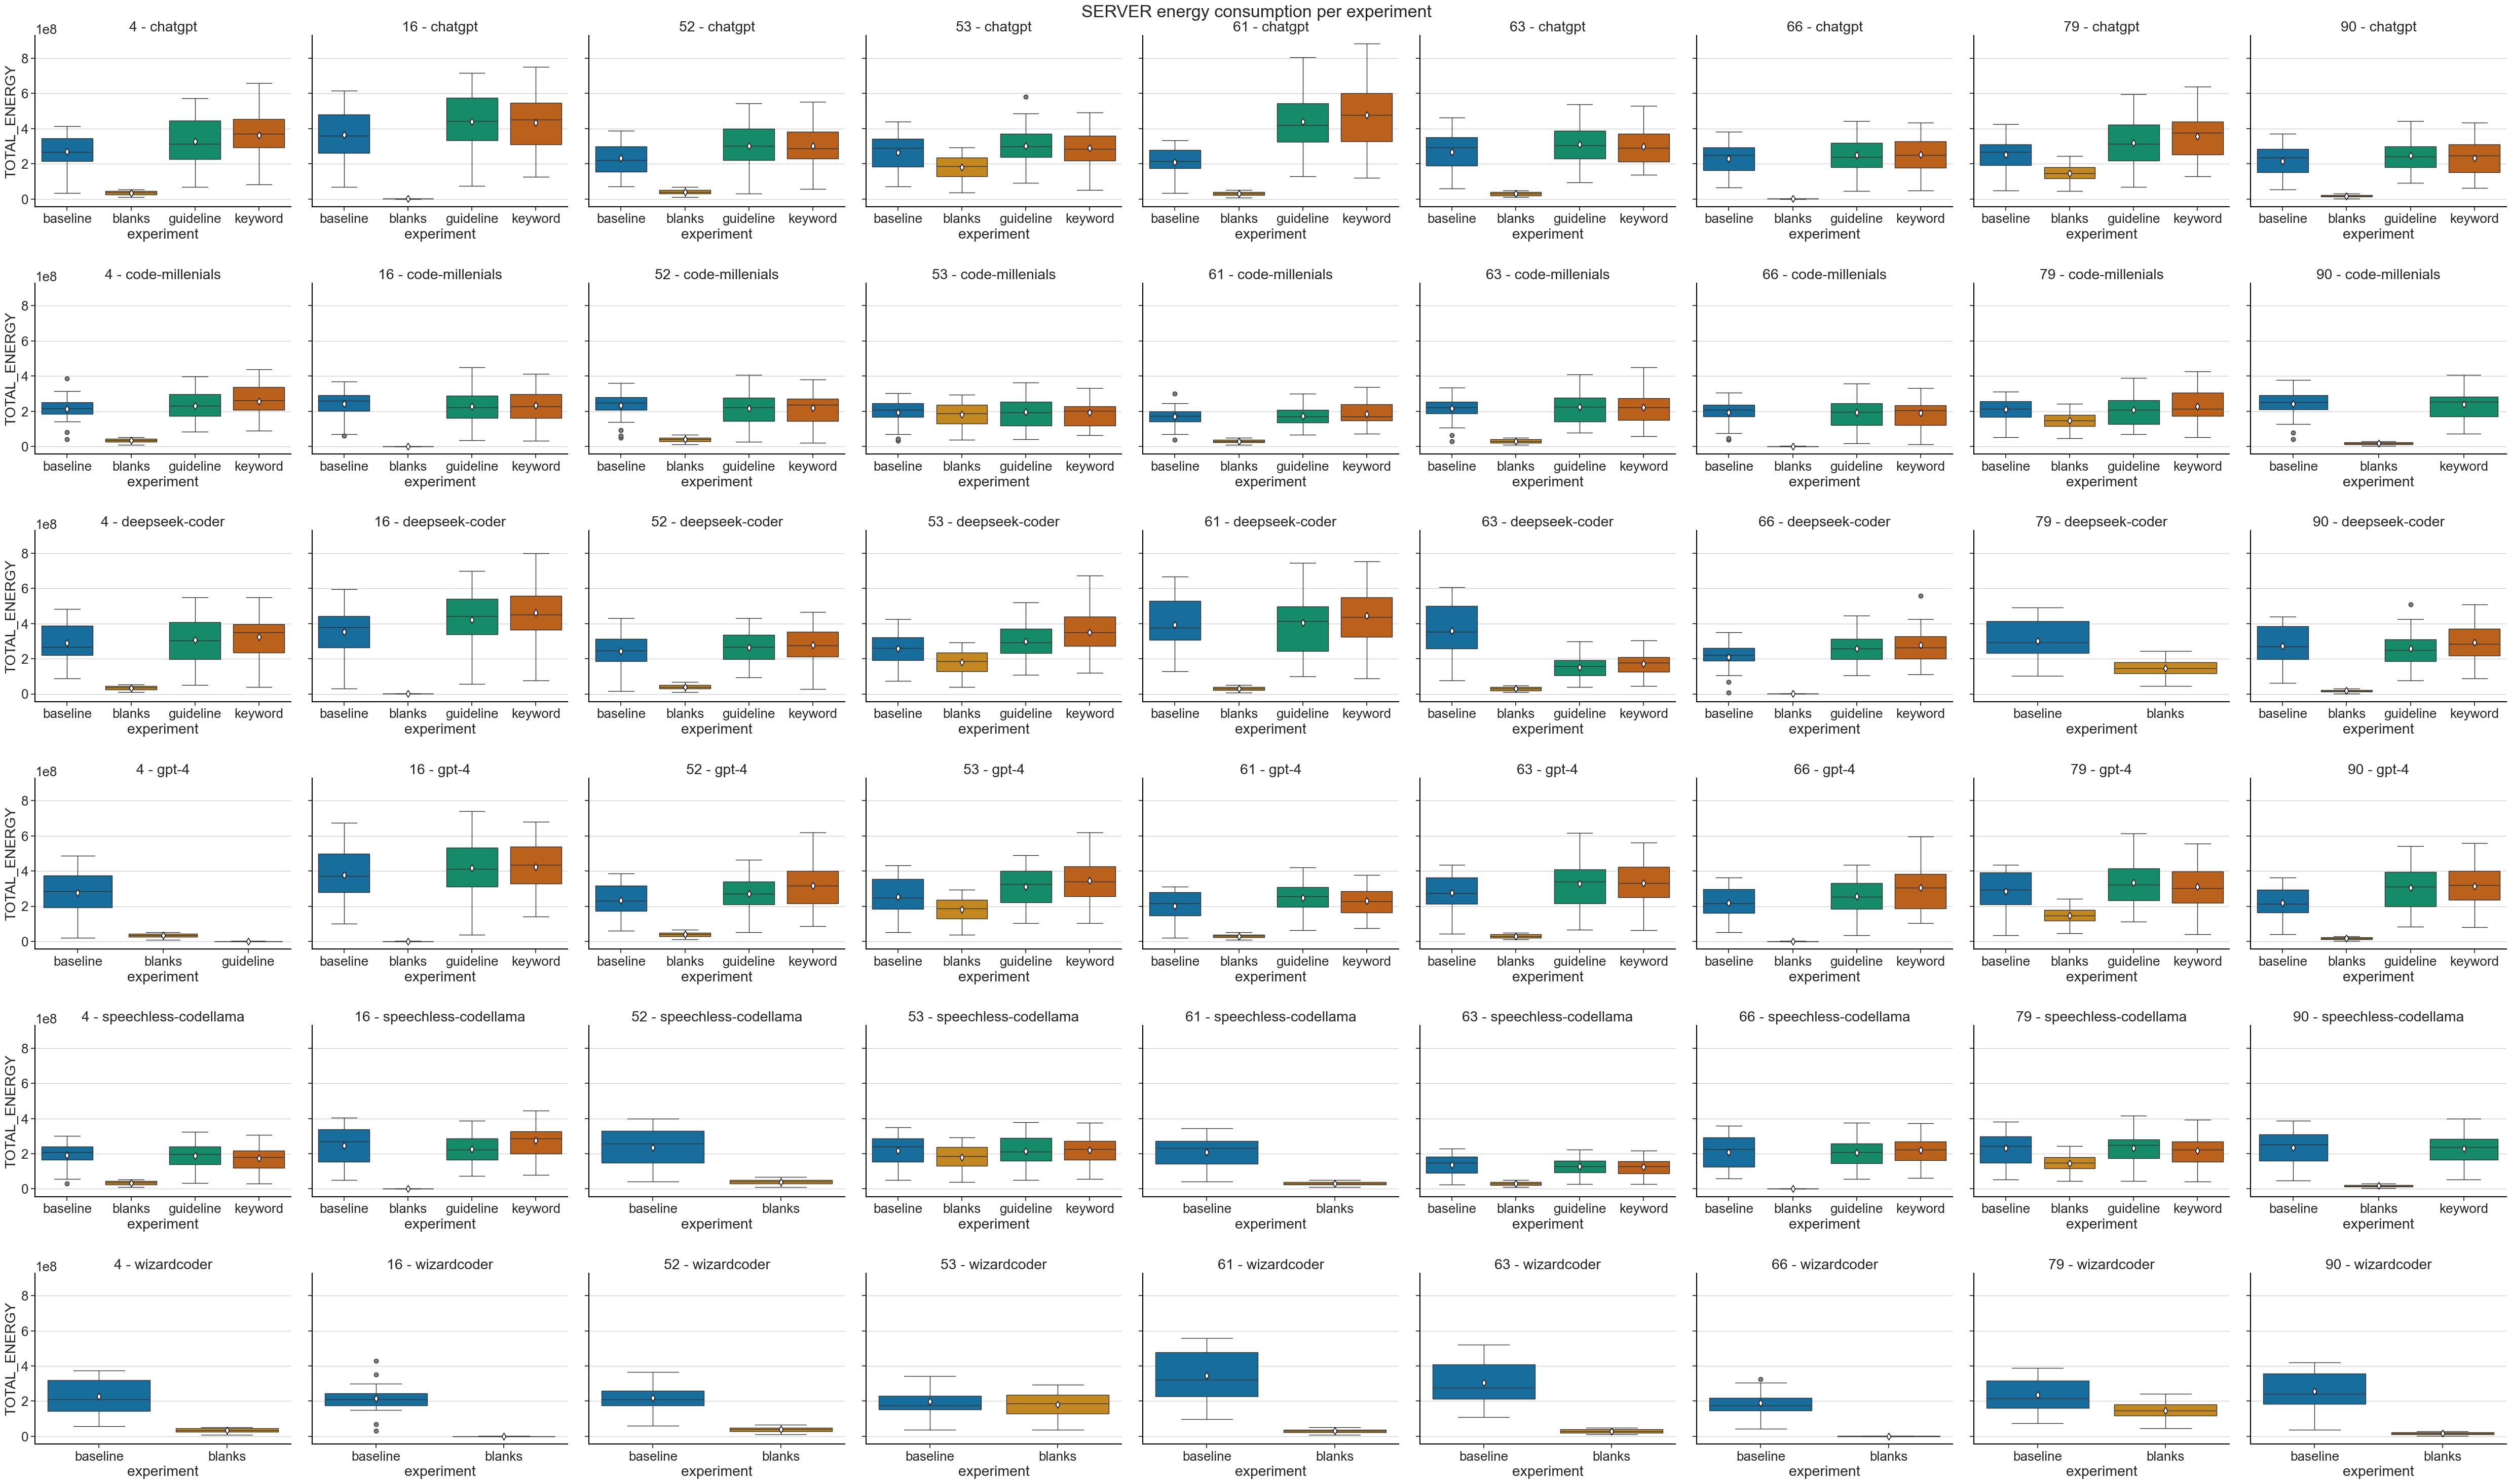

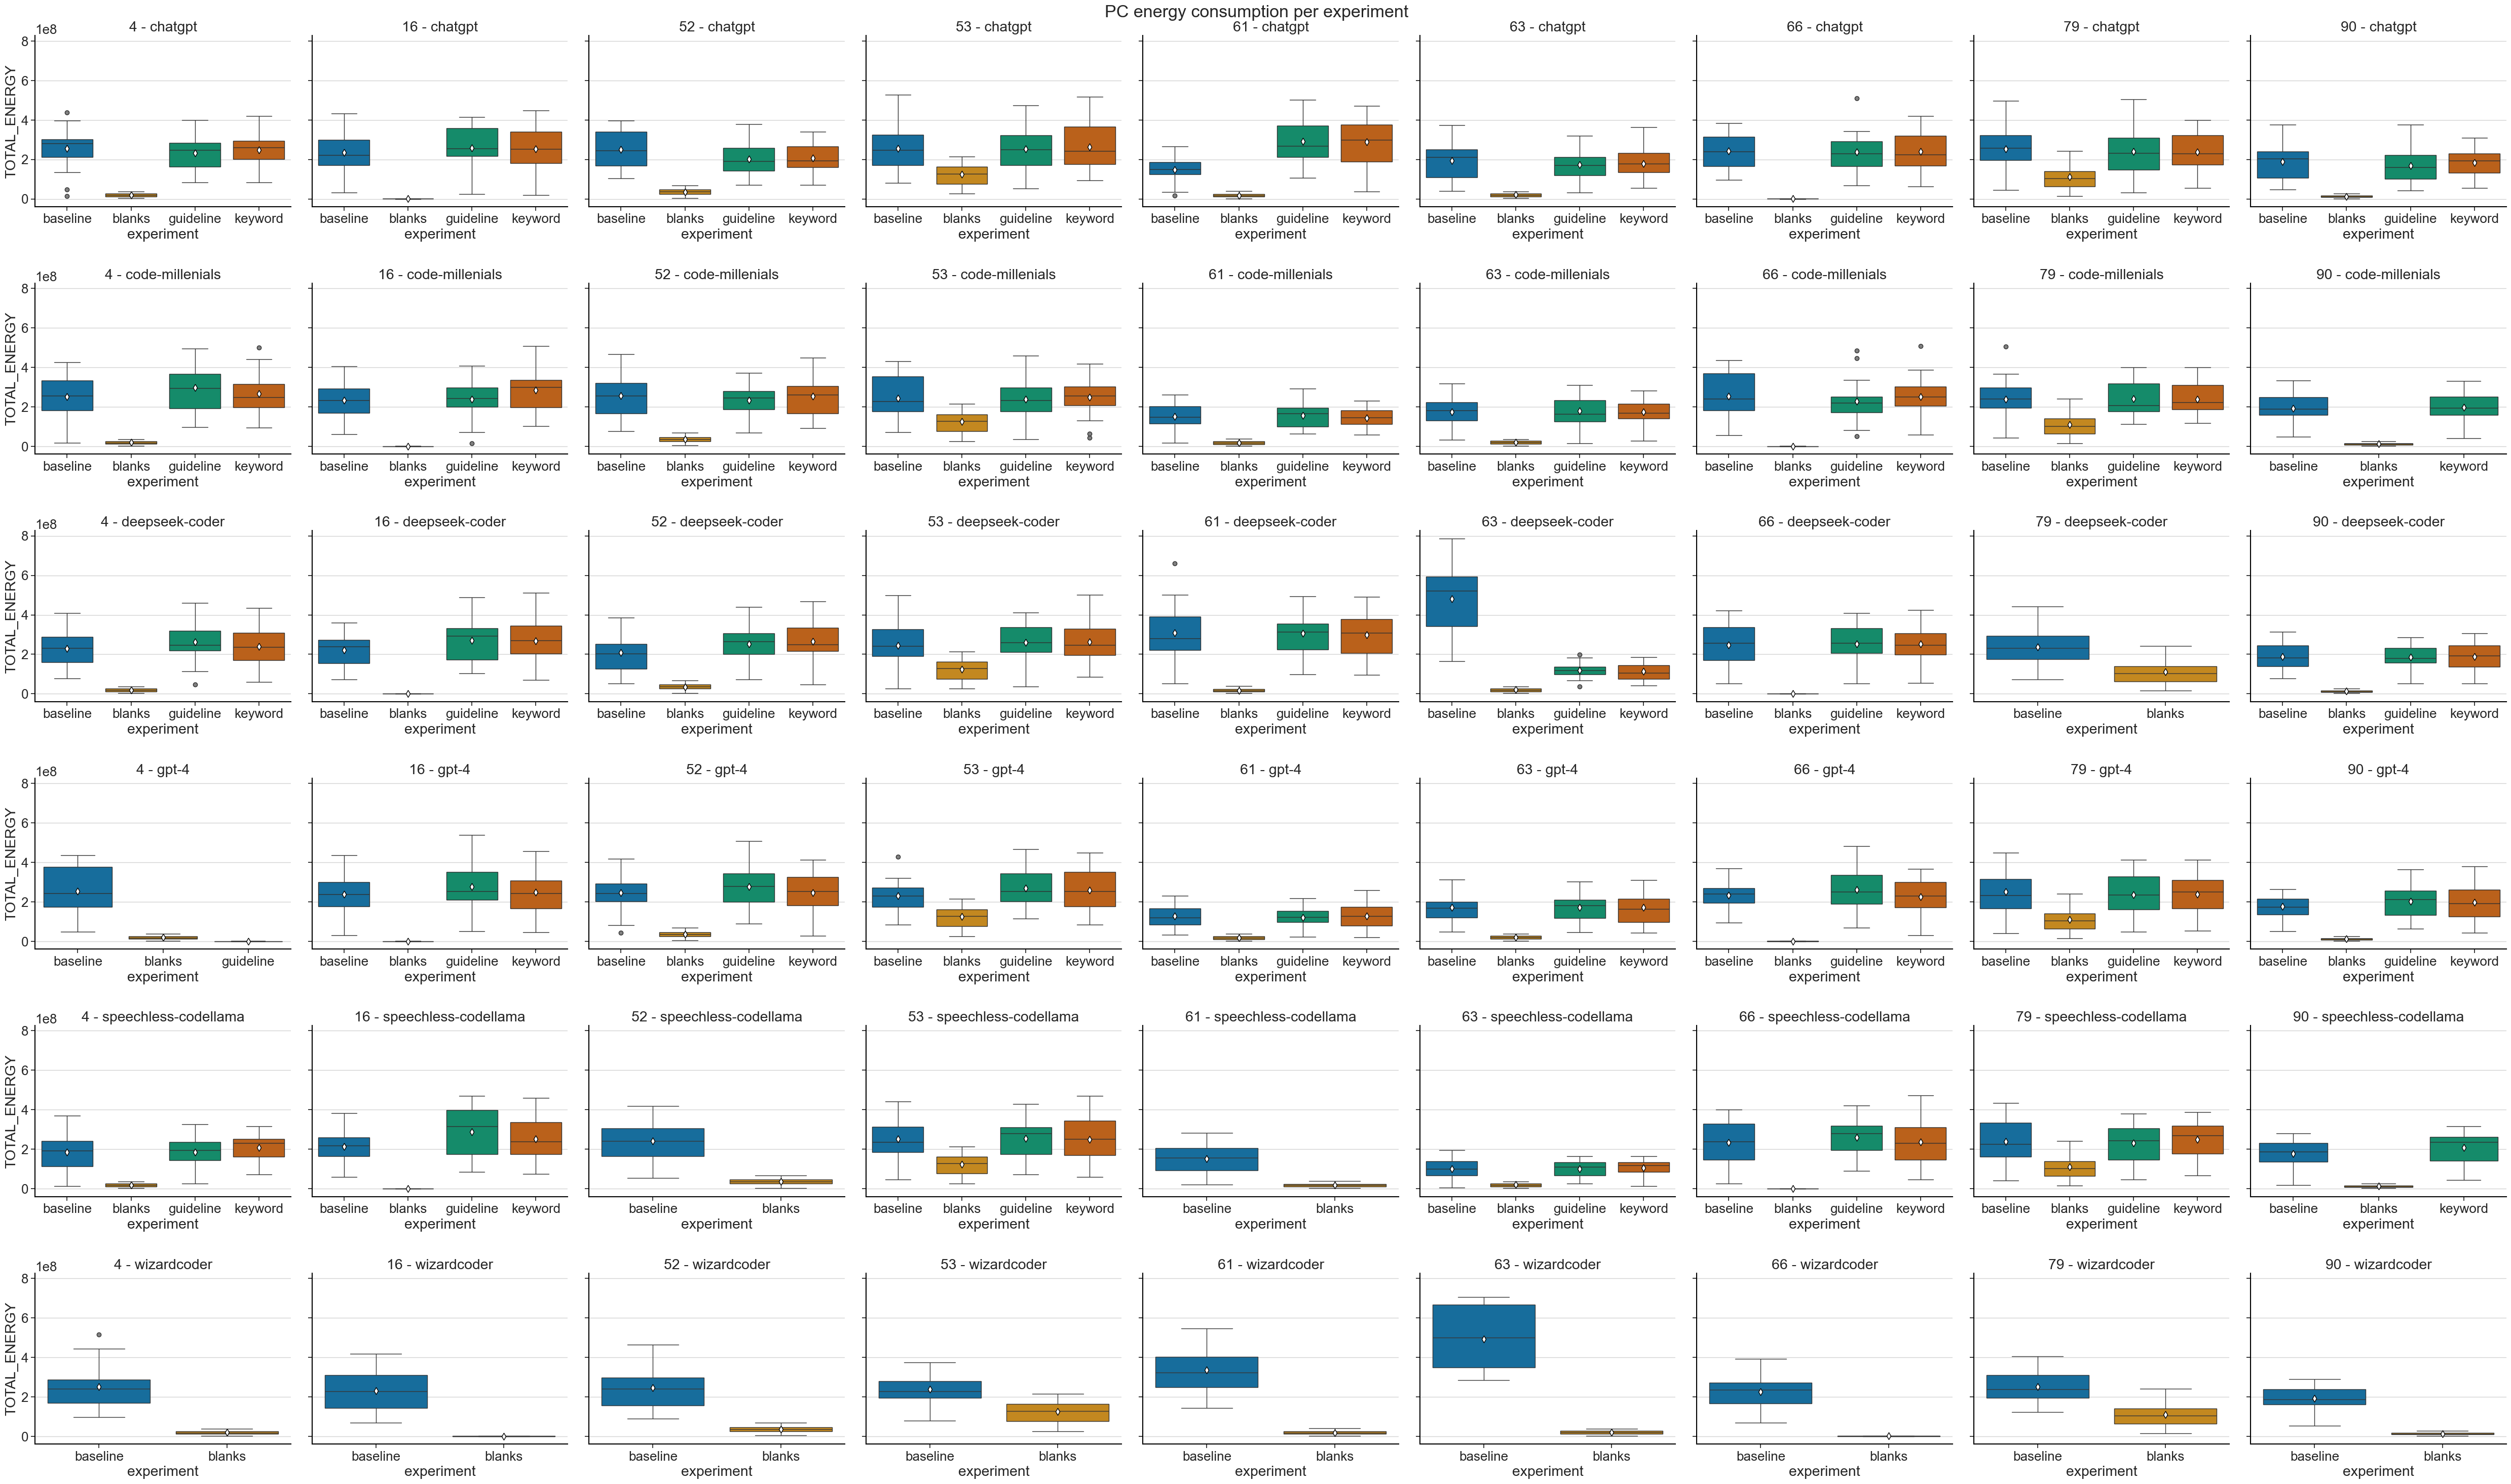

In [123]:
# disable warnings
import warnings
warnings.filterwarnings("ignore")

# calculate the total energy consumption per experiment per llm per code per repetition
energy_df = data_df.groupby(['device', 'experiment', 'llm', 'code', 'repetition'])['TOTAL_ENERGY'].sum().reset_index()

def big_boxplot(data, x, y, device):
	fig, axs = plt.subplots(nrows=6, ncols=9, figsize=(50, 30), sharey=True)
	for code_index, code in enumerate(data['code'].unique()):
		for llm_index, llm in enumerate(data['llm'].unique()):
			to_plot = data[data['code'] == code]
			to_plot = to_plot[to_plot['llm'] == llm]
			to_plot = to_plot.reset_index(drop=True)
			
			sns.boxplot(x=x, y=y, data=to_plot, showmeans=True, meanprops=custom_mean, palette="colorblind", flierprops=custom_outliers, ax=axs[llm_index, code_index])
			axs[llm_index, code_index].set_title(f'{code} - {llm}')
	plt.suptitle(device + ' energy consumption per experiment')
	plt.tight_layout()
	plt.savefig(f'./figures/{device}_energy_consumption_per_experiment.pdf', format='pdf')
	plt.show()

big_boxplot(energy_df[energy_df['device'] == 'SRV'], 'experiment', 'TOTAL_ENERGY', 'SERVER')
big_boxplot(energy_df[energy_df['device'] == 'PC'], 'experiment', 'TOTAL_ENERGY', 'PC')